In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False

분류 신경망 실습  
신경망을 이용해 와인 종류를 분류하는 모델을 만들어 본다.

In [2]:
# 일관된 결과값이 나오도록 random seed를 설정한다.
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
# 데이터 불러오기
from sklearn import datasets # 사이킷런이 제공하는 데이터셋을 사용하기 위해 import 한다.
raw_wine = datasets.load_wine() # 와인 데이터를 불러온다.

In [4]:
# 피쳐, 타겟 데이터 저장
X = raw_wine.data # 피쳐 데이터를 저장한다.
y = raw_wine.target # 타겟 데이터를 저장한다.
# 총 13개의 피쳐가 사용되는데, 이는 신경망을 생성할 때 사용된다.
X.shape

(178, 13)

In [5]:
# 타겟 데이터 종류 확인
# 타겟 데이터 종류를 확인함으로써 분류 문제인지 아니면 회귀 문제인지 파악할 수 있고, 분류 문제라면
# 몇 가지 클래스로 구분되는지 알 수 있다.
print(set(y))

{0, 1, 2}


In [6]:
# 타겟 데이터 원-핫 인코딩
from tensorflow.keras.utils import to_categorical # 원-핫 인코딩을 사용하기 위해 import 한다.
y_hot = to_categorical(y) # 타겟 데이터를 넣어서 원-핫 인코딩을 실행한다.
print(y_hot)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0.

In [7]:
# 트레이닝, 테스트 데이터 분할
from sklearn.model_selection import train_test_split # 트레이닝, 테스트 데이터 분할을 위해 import 한다.
X_tn, X_te, y_tn, y_te = train_test_split(X, y_hot, random_state=0) # 트레이닝 데이터와 테스트 데이터로 분할한다.
print(X_tn.shape, y_tn.shape, X_te.shape, y_te.shape)

(133, 13) (133, 3) (45, 13) (45, 3)


In [8]:
# 시퀀스 API 신경망 생성
from tensorflow.keras.models import Sequential # 시퀀스 API 신경망을 생성하기 위해 import 한다.
from tensorflow.keras.layers import Dense # 신경망에 추가할 완전 연결 layer를 생성하기 위해 import 한다.
from tensorflow.keras.layers import BatchNormalization # 배치 정규화 layer를 생성 하기 위해 import 한다.
from tensorflow.keras.layers import Activation # 활성화 함수 layer를 생성 하기 위해 import 한다.

# 분류 신경망은 모델 학습에 사용되는 피쳐 개수(n)와 클래스 개수(c)를 지정한다.
n = X_tn.shape[1]
c = len(set(y))
print('피쳐 개수: {}, 클래스 개수: {}'.format(n, c))
epochs = 50

# Sequential 객체를 선언 후 Sequential 모델에 add() 메소드로 layer를 추가해서 쌓아올린다.
model = Sequential() # 신경망 모델을 만든다.
# input_dim 속성으로 입력 데이터(피쳐)의 차원, units 속성으로 layer의 출력 차원을 지정한다.
# model.add(Dense(input_dim=n, units=20)) # 신경망 모델에 입력 layer를 추가한다.
# model.add(Activation('relu')) # 신경망 모델에 ReLu 활성화 함수 layer를 추가한다.
model.add(Dense(input_dim=n, units=20, activation='relu'))
model.add(BatchNormalization()) # 신경망 모델에 배치 정규화 layer를 추가한다.
# 분류 신경망은 구분해야 할 클래스 개수만큼 출력 노드 개수(units)를 지정한다.
# model.add(Dense(units=c)) # 신경망 모델에 출력 layer를 추가한다.
# model.add(Activation('softmax')) # 신경망 모델에 softmax 활성화 함수 layer를 추가한다.
model.add(Dense(units=c, activation='softmax'))
model.summary()

피쳐 개수: 13, 클래스 개수: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                280       
                                                                 
 batch_normalization (BatchN  (None, 20)               80        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3)                 63        
                                                                 
Total params: 423
Trainable params: 383
Non-trainable params: 40
_________________________________________________________________


In [9]:
# 모델 컴파일
# 분류 신경망은 loss 속성에 손실(비용, 오차)함수를 지정할 때 이진 분류 문제 binary_crossentropy를 지정하고, 
# 3개 이상의 클래스로 분류하는 다중 분류 문제에서는 categorical_crossentropy를 지정한다.
# optimizer 속성에 최적화 함수(일반적으로 adam)를 지정한다.
# metrics 속성에 평가 기준을 지정한다.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epoch: 전체 트레이닝 데이터셋 전체가 신경망을 통과하는 횟수  
iteration: 1 epoch를 마치는데 필요한 미니 배치 개수  
batch_size: 하나의 미니 배치에 속하는 데이터의 개수

In [10]:
# 신경망 학습
# 트레이닝 피쳐 데이터(X_tn)와 트레이닝 데이터에 따른 타겟 데이터(y_tn)를 지정하고 epochs 속성에
# epoch와 batch_size 속성에 batch_size를 지정한다.
hist = model.fit(X_tn, y_tn, epochs=epochs, batch_size=5)

Epoch 1/50
27/27 [==============================] - 1s 1ms/step - loss: 0.7509 - accuracy: 0.6541
Epoch 2/50
27/27 [==============================] - 0s 1ms/step - loss: 0.7974 - accuracy: 0.6241
Epoch 3/50
27/27 [==============================] - 0s 1ms/step - loss: 0.8227 - accuracy: 0.6165
Epoch 4/50
27/27 [==============================] - 0s 1ms/step - loss: 0.7515 - accuracy: 0.6692
Epoch 5/50
27/27 [==============================] - 0s 1ms/step - loss: 0.7261 - accuracy: 0.6692
Epoch 6/50
27/27 [==============================] - 0s 1ms/step - loss: 0.7511 - accuracy: 0.6015
Epoch 7/50
27/27 [==============================] - 0s 983us/step - loss: 0.8211 - accuracy: 0.6617
Epoch 8/50
27/27 [==============================] - 0s 1ms/step - loss: 0.7533 - accuracy: 0.6692
Epoch 9/50
27/27 [==============================] - 0s 1ms/step - loss: 0.7940 - accuracy: 0.6541
Epoch 10/50
27/27 [==============================] - 0s 973us/step - loss: 0.7595 - accuracy: 0.6316
Epoch 11/50
27/

In [11]:
# 신경망 학습 평가
print(model.evaluate(X_tn, y_tn)) # 트레이닝 피쳐 데이터를 트레이닝 피처 타겟 데이터와 학습 평가
print(model.evaluate(X_te, y_te)) # 테스트 피쳐 데이터를 테스트 피처 타겟 데이터와 학습 평가

5/5 [==============================] - 0s 1ms/step - loss: 0.2928 - accuracy: 0.8496
[0.2927686274051666, 0.8496240377426147]
2/2 [==============================] - 0s 2ms/step - loss: 0.2242 - accuracy: 0.9111
[0.2242351472377777, 0.9111111164093018]


In [12]:
# 정확도 및 손실 정도 시각화 준비
epoch = np.arange(1, epochs + 1)
# print(epoch)
accuracy = hist.history['accuracy'] # 모델 실행 결과에서 정확도만 얻어온다.
# print(accuracy)
loss = hist.history['loss'] # 모델 실행 결과에서 오차만 얻어온다.
# print(loss)

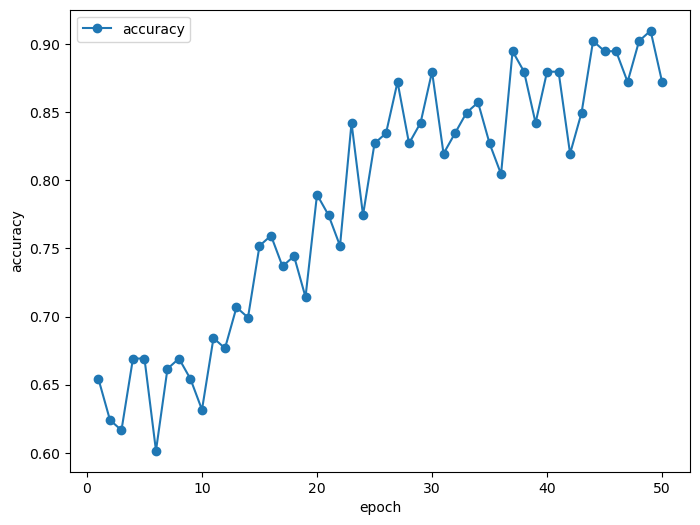

In [14]:
# 학습 정확도 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(epoch, accuracy, label='accuracy', marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
# 정확도 확인 결과 에포크 진행 단계별로 정확도가 상승하는 것을 볼 수 있다.

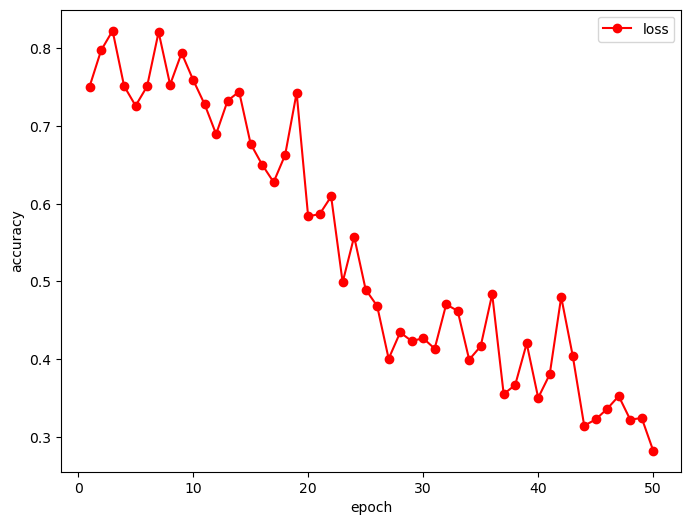

In [19]:
# 손실 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(epoch, loss, 'r', label='loss', marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
# 손실 확인 결과 에포크 진행 단계별로 손실이 점차 낮아지는 것을 볼 수 있다.

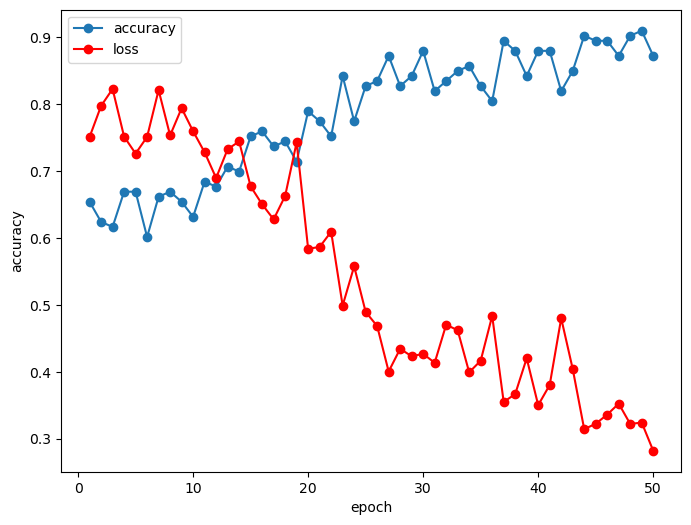

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(epoch, accuracy, label='accuracy', marker='o')
plt.plot(epoch, loss, 'r', label='loss', marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()